## 1. Обзор данных
В этой части рассматривается выборка данных с целью ознакомления. В репозитории находятся немного другие данные, по причине того, что объем данных не позволяет загрузить все.

Загрузим готовые результаты подсчета проекций (бинарный файл, записанные подряд структуры).

In [119]:
#!g1.1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import scipy.stats as sps
#import imageio
#import seaborn as sns
import os
import time

from sklearn.model_selection import train_test_split

from collections import defaultdict

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import nn_architectures
import nn_tools
import data_load

import subprocess

import warnings
warnings.filterwarnings('ignore')

#sns.set(font_scale=1.3)
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

In [2]:
#!L
data = data_load.load_dataset('./data_part/')
data.head()

,PupX,PupY,PupR,IriX,IriY,IriR,1,2,3,4,...,631,632,633,634,635,636,637,638,639,640
Filename,,,,,,,,,,,,,,,,,,,,,
2463(r-1-1)101231-233000_e_00_0000.bmp,391,263,45,392,263,121,0,0,0,0,...,1651,1665,1637,1596,1496,1400,1212,1012,801,607
2463(r-1-1)101231-233000_e_00_0001.bmp,392,261,37,396,261,120,0,0,0,0,...,2639,2544,2358,2119,1893,1707,1972,2235,2490,2753
2463(r-1-1)101231-233000_e_00_0002.bmp,385,270,36,389,270,120,0,0,0,0,...,2014,1835,1721,1688,1628,1629,1927,2254,2625,3028
2463(r-1-1)101231-233000_e_00_0003.bmp,292,273,34,296,273,120,0,0,0,0,...,1594,1800,1977,2195,2338,2451,2269,2027,1746,1433
2463(r-1-1)101231-233000_e_00_0004.bmp,363,262,38,367,262,119,1017,1017,1017,1017,...,1820,1782,1746,1708,1668,1662,1489,1281,1024,807


Рассмотрим сами проекции. Рассматривать надо 640 проекций, поскольку в силу ограничения размером картинки дальше может быть только некоторый шум.

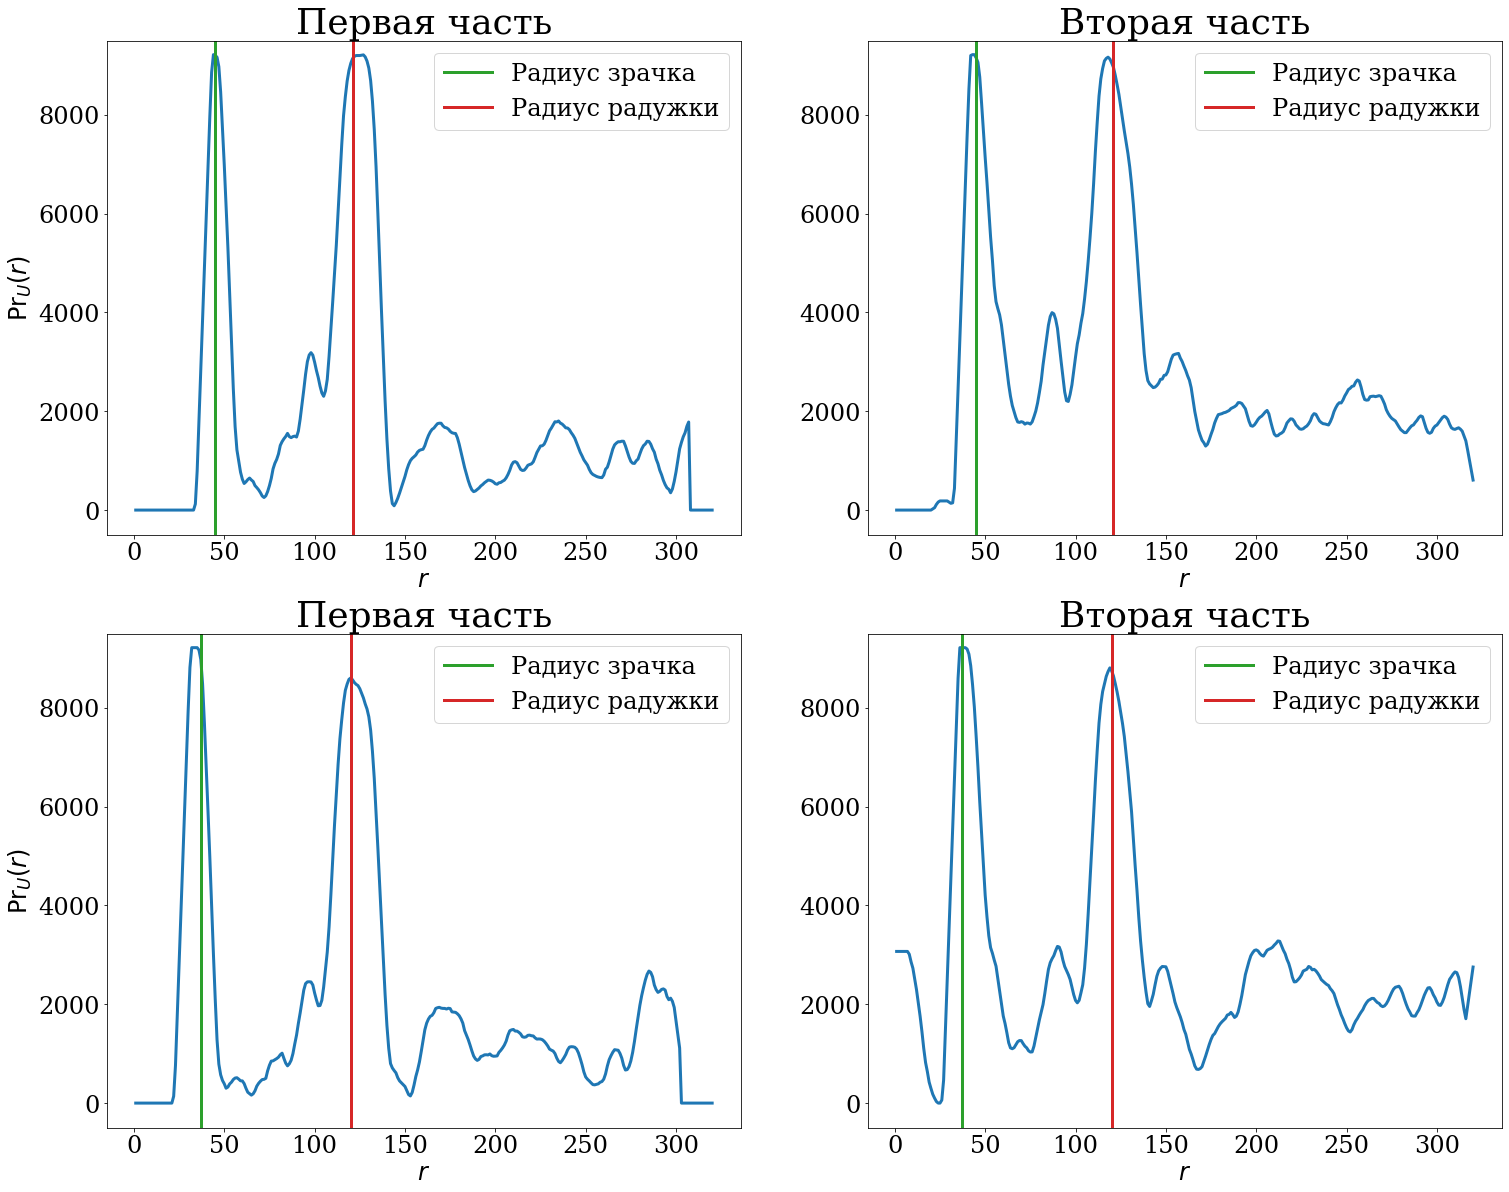

In [3]:
#!L
plt.figure(figsize=(25, 20))
for i in range(2):
    plt.subplot(2, 2, 2 * i + 1)
    plt.plot(data.loc[data.index[i], np.arange(1, 321)])
    plt.axvline(data.loc[data.index[i], 'PupR'], color='C2', label='Радиус зрачка')
    plt.axvline(data.loc[data.index[i], 'IriR'], color='C3', label='Радиус радужки')
    plt.title('Первая часть')
    plt.xlabel('$r$')
    plt.ylabel('$\\mathsf{Pr}_U(r)$')
    #plt.ylabel(f'Изображение {i+1}')
    plt.legend()
    plt.ylim((-500, 9500))
    
    plt.subplot(2, 2, 2 * i + 2)
    plt.plot(np.arange(1, 321), data.loc[data.index[i], np.arange(321, 641)])
    plt.axvline(data.loc[data.index[i], 'PupR'], color='C2', label='Радиус зрачка')
    plt.axvline(data.loc[data.index[i], 'IriR'], color='C3', label='Радиус радужки')
    plt.title('Вторая часть')
    plt.xlabel('$r$')
    plt.legend()
    plt.ylim((-500, 9500))

## 2. Вычислительный эксперимент

В данной части происходит обучение нейронной сети и ее выяснение ее возможностей.

In [4]:
#!L
sample = data[np.arange(1, 641)].to_numpy().reshape(-1, 2, 320) / 9500
target = data[['PupR', 'IriR']].to_numpy()

In [5]:
#!L
train_sample, test_sample, train_target, test_target = train_test_split(
    sample, target, test_size=0.2, random_state=42
)
train_sample, val_sample, train_target, val_target = train_test_split(
    train_sample, train_target, test_size=1/5, random_state=42
)

In [6]:
#!L
train_sample.shape, train_target.shape

((5492, 2, 320), (5492, 2))

In [7]:
#!L
val_sample.shape, val_target.shape

((1373, 2, 320), (1373, 2))

In [8]:
#!L
test_sample.shape, test_target.shape

((1717, 2, 320), (1717, 2))

In [9]:
#!L
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
batch_size = 128

In [10]:
#!L
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, data, target):
        super(SimpleDataset, self).__init__()
        
        assert data.shape[0] == target.shape[0]
        self.data = data
        self.target = target
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.data[idx]), torch.FloatTensor(self.target[idx])

In [122]:
#!L
train_dataset = SimpleDataset(train_sample, train_target)
train_generator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = SimpleDataset(val_sample, val_target)
val_generator = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataset = SimpleDataset(test_sample, test_target)
test_generator = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [61]:
#!L
def conv_train_iter(exec_no):
    conv_net = nn_architectures.Convolutional5Layers().to(device)
    criterion = nn.MSELoss()
    conv_optimizer = torch.optim.Adam(conv_net.parameters(), lr=3e-3)
    history = nn_tools.train(
        conv_net, criterion, conv_optimizer,
        train_generator,
        val_generator,
        num_epochs=200,
        device=device,
        save_path='out/conv/{}.model'.format(exec_no),
        ylim_loss=(0, 20), ylim_mape=(0, 0.1)
    )
    return history

In [13]:
#!L
torch.set_num_threads(1)

Time elapsed: 0.637s


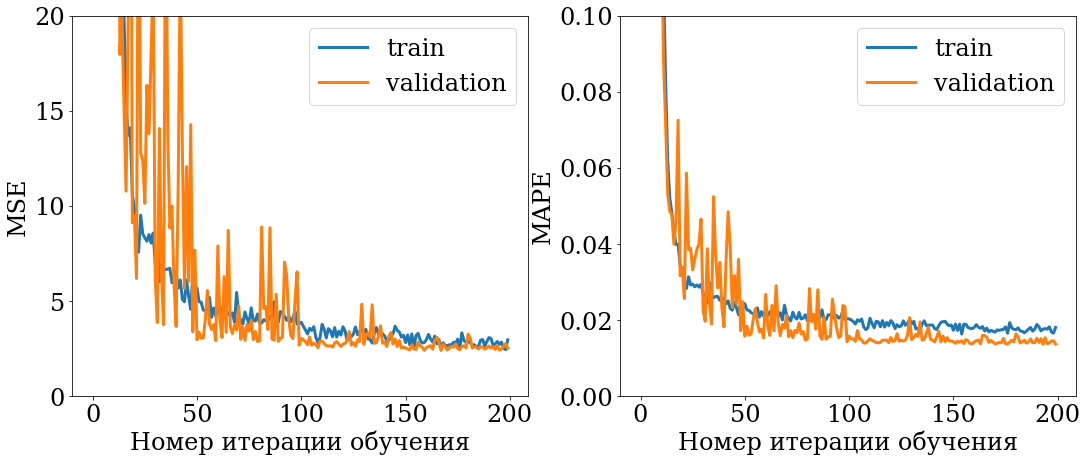

In [62]:
#!L
history = nn_tools.accumulate_histories(conv_train_iter, num_executions=50)
torch.save(history, 'out/conv/history')

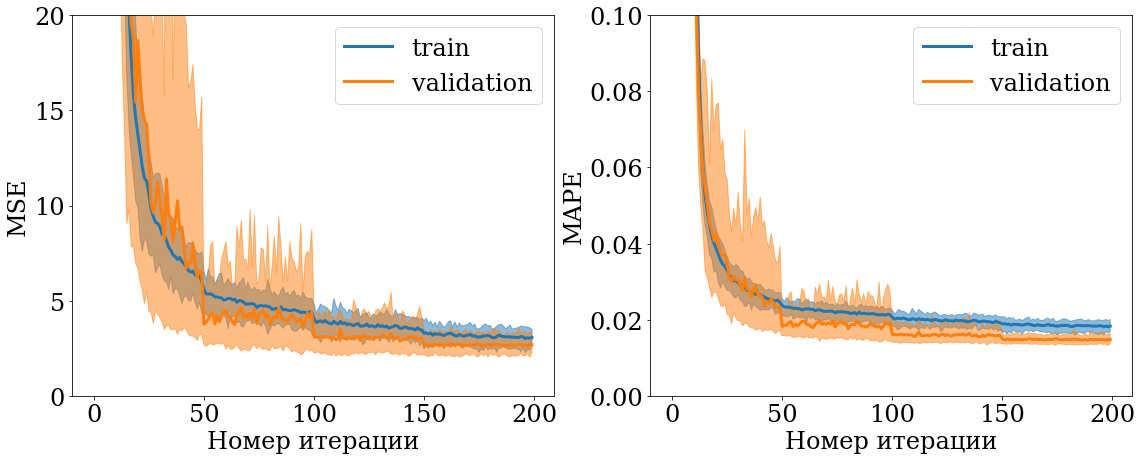

In [75]:
#!g1.1
nn_tools.visualize_histories(history, figsize=(19, 7), q=(0, 0.95), ylim_loss=(0, 20), ylim_mape=(0, 0.1))

Загрузим данные нейросетей, обученных в других ноутбуках:

In [144]:
#!g1.1
conv_history = torch.load('out/conv/history')
conv2_history = torch.load('out/conv2/history')
linear_history = torch.load('out/linear/history')
rnn_history = torch.load('out/rnn/history')

Альтернативная сверточная модель:

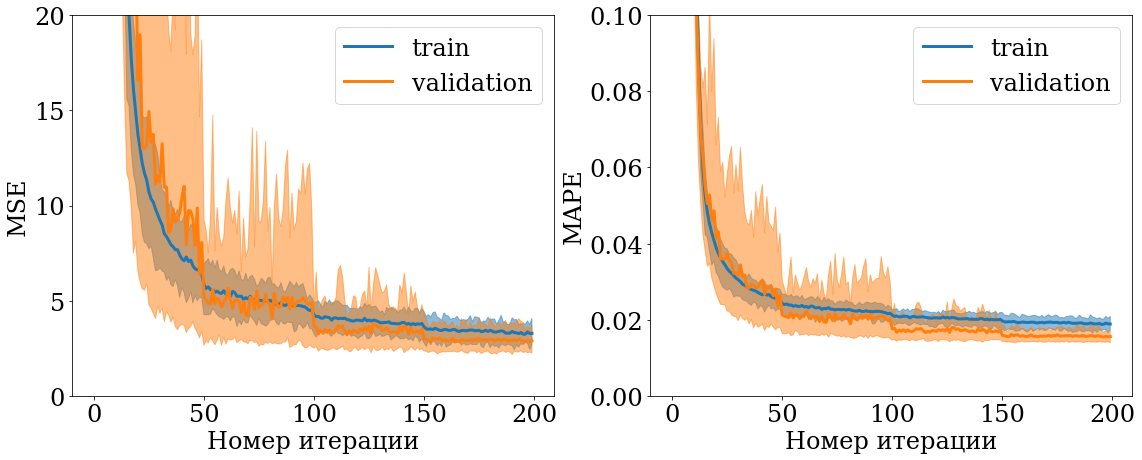

In [76]:
#!g1.1
nn_tools.visualize_histories(conv2_history, q=(0, 0.95), figsize=(19, 7), ylim_loss=(0, 20), ylim_mape=(0, 0.1))

Линейная модель: 

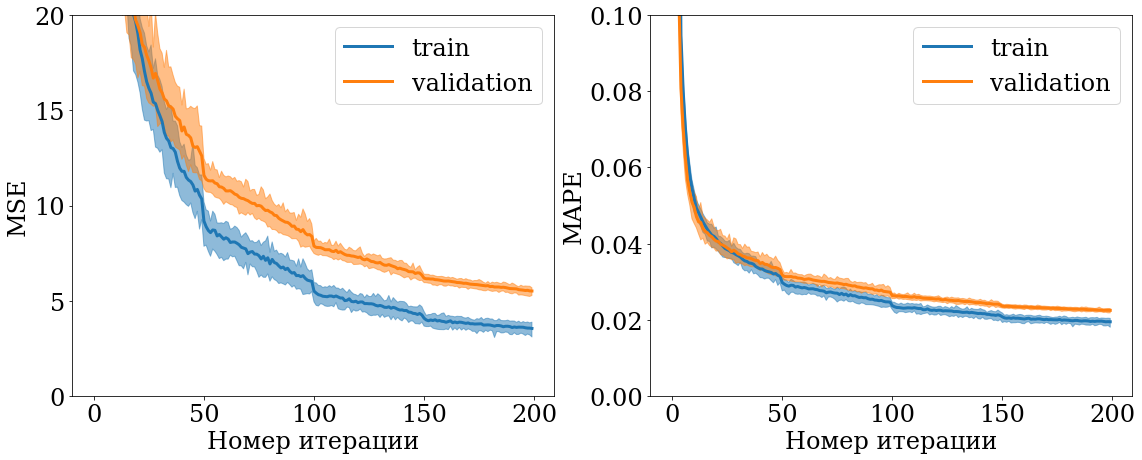

In [77]:
#!g1.1
nn_tools.visualize_histories(linear_history, q=(0, 0.95), figsize=(19, 7), ylim_loss=(0, 20), ylim_mape=(0, 0.1))

Реккурентная модель:

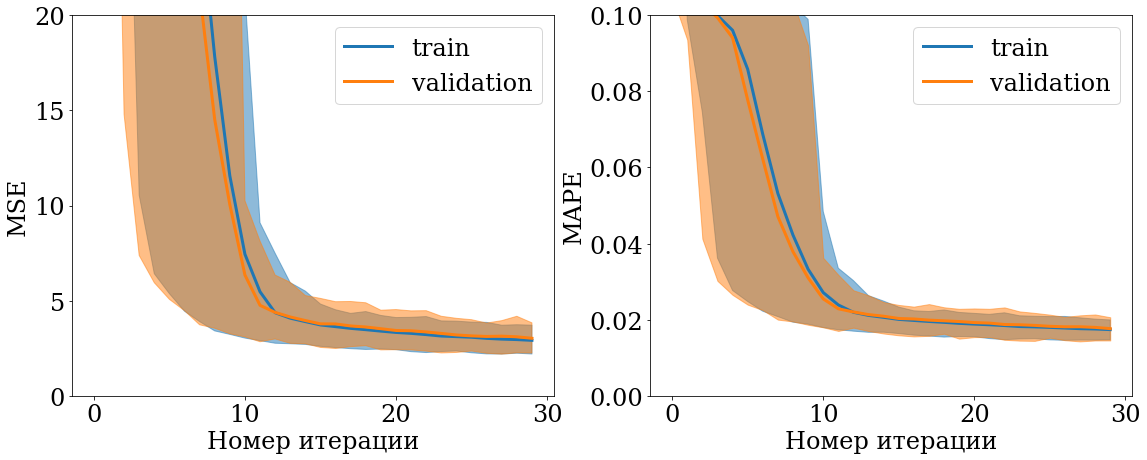

In [78]:
#!g1.1
nn_tools.visualize_histories(rnn_history, q=(0, 0.95), figsize=(19, 7), ylim_loss=(0, 20), ylim_mape=(0, 0.1))

Сравнение моделей на валидации:

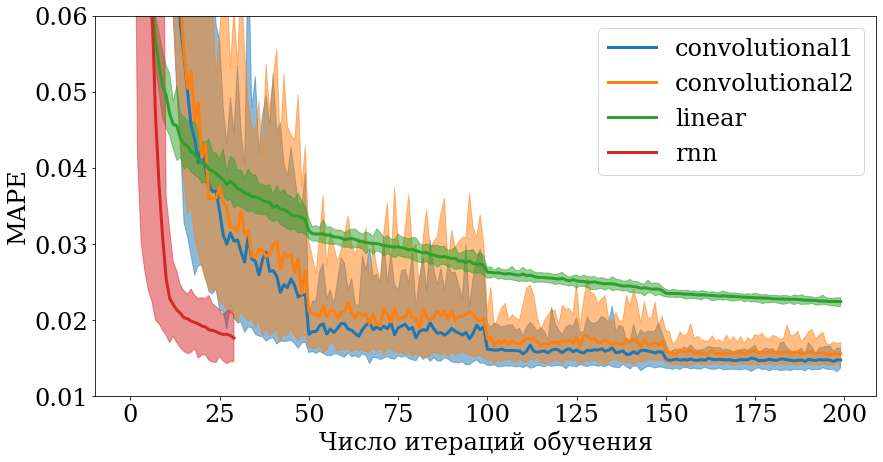

In [147]:
#!g1.1
histories = [conv_history, conv2_history, linear_history, rnn_history]
labels = [
    "convolutional1",
    "convolutional2",
    "linear",
    "rnn"
]
colors = ['C0', 'C1', 'C2', 'C3']
q = (0, 0.95)

plt.figure(figsize=(14, 7))
for hist, lab, col in zip(histories, labels, colors):
    plt.plot(hist['mape']['mean']['val'], label=lab, color=col)
    plt.fill_between(
        np.arange(len(hist['mape']['mean']['val'])),
        np.quantile(hist['mape']['all']['val'], q[0], axis=0),
        np.quantile(hist['mape']['all']['val'], q[1], axis=0),
        color=col, alpha=0.5
    )
plt.legend()
plt.xlabel('Число итераций обучения')
plt.ylabel('MAPE')
plt.ylim((0.01, 0.06));

Посчитаем качество на тесте:

In [146]:
#!g1.1
def count_test_quality(models_path, test_generator, model_class, model_args=(), model_kwargs={}):
    mapes = []
    models = os.listdir(models_path)
    for mod in models:
        if not mod.endswith('.model'):
            continue
        model = model_class(*model_args, **model_kwargs)
        model.load_state_dict(torch.load(os.path.join(models_path, mod)))
        model.to(device)
        model.eval()
        
        mape = []
        
        with torch.no_grad():
            for X_batch, y_batch in test_generator:
                X_batch = X_batch.to(device)
                target = y_batch.numpy()
                logits = model(X_batch).cpu().numpy()
                mape = mape + (np.abs(logits - target) / target).tolist()
        
        mapes.append(np.mean(mape))
    return mapes

In [105]:
#!g1.1
conv1_mape = count_test_quality('out/conv/', test_generator, nn_architectures.Convolutional5Layers)

In [116]:
#!g1.1
conv2_mape = count_test_quality('out/conv2/', test_generator, nn_architectures.Convolutional)

In [117]:
#!g1.1
linear_mape = count_test_quality('out/linear/', test_generator, nn_architectures.Linear2Layers)

Для реккурентной сети необходимо поменять местами размерности.

In [124]:
#!g1.1
test_sample_rec = np.transpose(test_sample, axes=(0, 2, 1))
test_dataset_rec = SimpleDataset(test_sample_rec, test_target)
test_generator_rec = DataLoader(test_dataset_rec, shuffle=False, batch_size=batch_size)

In [125]:
#!g1.1
rnn_mape = count_test_quality('out/rnn/', test_generator_rec, nn_architectures.Reccurent, model_kwargs={'hidden_size': 20, 'num_layers': 3})

Функция для подсчета числа обучаемых параметров сети:

In [133]:
#!g1.1
def count_parameters(model_class, model_args=(), model_kwargs={}):
    model = model_class(*model_args, **model_kwargs)
    return sum(p.numel() for p in model.parameters())

In [138]:
#!g1.1
params_count = [
    count_parameters(nn_architectures.Convolutional5Layers),
    count_parameters(nn_architectures.Convolutional),
    count_parameters(nn_architectures.Linear2Layers),
    count_parameters(nn_architectures.Reccurent, model_kwargs={'hidden_size': 20, 'num_layers': 3})
]

Посчитаем доверительные интервалы и средние значения:

In [141]:
#!g1.1
q = [0, 0.95]

mapes = [conv1_mape, conv2_mape, linear_mape, rnn_mape]
data = []

for mape, cnt in zip(mapes, params_count):
    data.append([
        np.mean(mape),
        '({:.4f}, {:.4f})'.format(np.quantile(mape, q[0]), np.quantile(mape, q[1])),
        cnt
    ])
    
data = pd.DataFrame(
    data,
    index=['Convolutional1', 'Convolutional2', 'Linear', 'Recurrent'],
    columns=['Mean MAPE value', 'MAPE confidence interval', 'Parameters count'])

In [143]:
#!g1.1
data

,Mean MAPE value,MAPE confidence interval,Parameters count
Convolutional1,0.013916,"(0.0132, 0.0147)",56831
Convolutional2,0.014789,"(0.0139, 0.0158)",17655
Linear,0.022104,"(0.0215, 0.0224)",166402
Recurrent,0.017666,"(0.0145, 0.0205)",14962
